In [2]:
#@title Load Data from Dropbox
#!wget -O data_input.csv https://www.dropbox.com/s/g9xvk71iio3rcmu/single_input?dl=0
#!wget -O data_output.csv https://www.dropbox.com/s/szkgat2th6x92mu/single_output?dl=0

In [1]:
#@title Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from scipy.signal import argrelextrema as ext
import tensorflow as tf

import chillmax as cm

from tqdm import tqdm

from sklearn.model_selection import train_test_split

### Read data

In [2]:
#@title Reading Data
dfi = pd.read_csv('data_input.csv')
dfi[:6]
dfo = pd.read_csv('data_output.csv')
dfi[:6]

print(dfi.shape, dfo.shape)

(9869, 21) (9869, 61)


In [3]:
base_configs = dfi.to_numpy()
#cfgs = base_configs

# or genereate
N = 6 # Number of variations
frac = 0.01 # Variation strength
generated = []

# Generate
for i, cfg in enumerate(base_configs):
    _gen_cfg = np.tile(cfg, (N,1)) * np.random.uniform(1-frac,1+frac, (N, len(cfg)))
    
    generated.append(_gen_cfg)
        
    #if i == 3: break

cfgs = np.vstack(generated)
cfgs.shape


(59214, 21)

NameError: name 'get_spans_overlap' is not defined

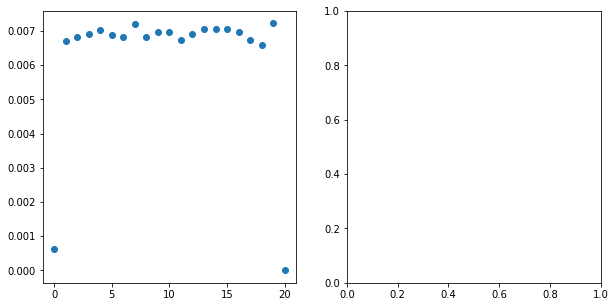

In [4]:
# Let's inspect what they look like and what boost factors they give
# Plots inputs and outputs
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs = axs.flatten()
for i in np.random.choice(np.arange(cfgs.shape[0]), 10):
    axs[0].scatter(np.arange(len(cfgs[i])), cfgs[i], label=i)
    
    spans = get_spans_overlap(get_spans(cfgs[i])) # span overlap can result in low sampling in wide peaks
    freqs = find_sampling(spans)
    
    axs[1].plot(cm.sim.boost(freqs*1e9, spacings=cfgs[i]), label=i)
axs[0].set_title("Disks")
axs[1].set_title("Boosts");

### Generate boost samplings

In [6]:
#cfg = base_configs[0]

def get_spans(cfg, freq=(21, 24), plot=False):
    import scipy
    from scipy.signal import chirp, find_peaks, peak_widths

    if len(freq) != 2:
        freqs = freq # passed linspace i guess
    else:
        freqs = np.linspace(freq[0], freq[1], 2000)
        
    boost = cm.sim.boost(freqs*1e9, spacings=cfg)
    
    if plot:
        fig, axs = plt.subplots(figsize=(7,5))
        axs.plot(freqs, boost)
    
    peaks, _ = find_peaks(boost, prominence=np.max(boost)*0.1)
    results_full = peak_widths(boost, peaks, rel_height=0.98)

    if plot: 
        axs.plot(freqs[peaks], boost[peaks], "x", label="Peaks")


    def find(peak, freqs):
        rmin, rmax = np.floor(peak[0]).astype(int), np.ceil(peak[1]).astype(int)
        fmin, fmax = freqs[rmin], freqs[rmax]
        scale = 0.1
        size = fmax - fmin
        extra = max(0.005, size * 0.08)
        #print(extra)
        return fmin - extra, fmax + extra

    peaks = np.array(results_full[2:]).T
    spans = []
    for i, peak in enumerate(peaks):
        if plot:
            axs.axvspan(*find(peak, freqs), alpha=0.5, label=f'Peak {i}', color=f'C{i}')
        spans.append(find(peak, freqs))
        
    np.min(np.array(spans))
    
    if plot:
        axs.legend()
        plt.xlim(np.min(np.array(spans)), np.max(np.array(spans)))
    return np.array(spans)
    
#get_spans(cfg, plot=True)

def get_spans_overlap(spans):
    sorted_by_lower_bound = sorted(spans, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            # we know via sorting that lower[0] <= higher[0]
            if higher[0] <= lower[1]:
                upper_bound = max(lower[1], higher[1])
                merged[-1] = (lower[0], upper_bound)  # replace by merged interval
            else:
                merged.append(higher)
    return np.array(merged)

#get_spans_overlap(get_spans(cfg))

def find_sampling(spans):
    pts = []
    for i, span in enumerate(spans):
        pts.append(np.linspace(*span, 200))
    pts.append(np.arange(21, 24, 0.1))
    return np.sort(np.hstack(pts), kind='heapsort')

def find_split_sampling(spans, cfgs):
    pts = []
    for i, span in enumerate(spans):
        pts.append(np.linspace(*span, 200))
    cfgs = np.tile(cfgs, (len(pts), 1))
    return np.array(pts), cfgs
   
lfreqs = []
lcfgs = []
from tqdm import tqdm
for i, cfg in enumerate(tqdm(cfgs[:500])):
    spans = get_spans_overlap(get_spans(cfg)) # span overlap can result in low sampling in wide peaks
    #spans = get_spans(cfg)
    #freqs.append(find_sampling(spans))
    f, c = find_split_sampling(spans, cfg)
    lfreqs.append(f)
    lcfgs.append(c)

Sfreqs = np.vstack(lfreqs)
Scfgs = np.vstack(lcfgs)

#     fig, axs = plt.subplots(1,2, figsize=(14, 5))
#     xar = find_sampling(spans)
#     axs[0].scatter(xar, cm.sim.boost(xar*1e9, spacings=cfg), s=0.5, c='black')
#     axs[1].scatter(xar, cm.sim.boost(xar*1e9, spacings=cfg), s=0.5, c='black')
#     axs[1].set_xlim(np.min(spans)-0.1, np.max(spans)+0.1)

100%|██████████| 500/500 [00:15<00:00, 31.68it/s]


In [7]:
def add_shifts(freqs, cfgs):
    lfreqs = []
    lcfgs = []
    
    for f, c in zip(freqs, cfgs):
        for _s in [-0.1, 0.05, 0.15]:
            lfreqs.append(f)
            lcfgs.append(c)

    return np.vstack(lfreqs), np.vstack(lcfgs)
            
Pfreqs, Pcfgs = add_shifts(Sfreqs, Scfgs)

In [8]:
def generate(freqs, cfgs):
    boosts = []
    from tqdm import tqdm
    for i, (freq, cfg) in enumerate(tqdm(zip(freqs, cfgs))):
        boosts.append(cm.sim.boost(freq*1e9, spacings=cfg))
    return boosts
                      
#boosts = generate(freqs[::3], cfgs[::3])
boosts = generate(Pfreqs, Pcfgs)

1797it [00:18, 96.48it/s] 


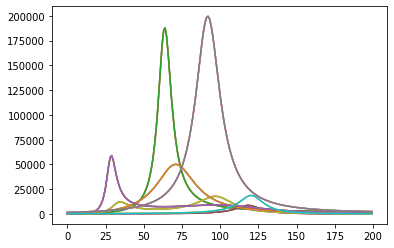

In [9]:
for b in boosts[:20]:
    plt.plot(b);

In [10]:
# Orig
X_train, X_test, y_train, y_test = train_test_split(np.array(dfi.to_numpy(), dtype=float), 
                                                    np.array(dfo.to_numpy(), dtype=float), 
                                                    test_size=0.1, shuffle=False)

In [11]:
# Resampled
# X_train, X_test, f_train, f_test, y_train, y_test = train_test_split(np.array(cfgs[::3], dtype=float), 
#                                                     np.array(freqs[::3]).astype(float),
#                                                     np.array(boosts).astype(float), 
#                                                     test_size=0.1, shuffle=False)

X_train, X_test, f_train, f_test, y_train, y_test = train_test_split(Pcfgs, 
                                                    Pfreqs,
                                                    boosts, 
                                                    test_size=0.1, shuffle=False)

# y_train = np.nan_to_num(y_train, nan=-1)
# y_test = np.nan_to_num(y_test, nan=-1)


In [12]:
list(map(np.shape, [X_train, X_test, f_train, f_test, y_train, y_test]))

[(1617, 21), (180, 21), (1617, 200), (180, 200), (1617, 200), (180, 200)]

### A bit of preprocessing

In [13]:
#@title Transform
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, Normalizer, RobustScaler, FunctionTransformer
scalerX = QuantileTransformer()
#scalerF = QuantileTransformer()
def ret(V):
    return np.nan_to_num(V, nan=-1)
scalerF = FunctionTransformer(ret)
scalerY = QuantileTransformer()
Xt_train = scalerX.fit_transform(X_train) 
#ft_train = scalerF.fit_transform(f_train) 
yt_train = scalerY.fit_transform(y_train) 

Xt_test = scalerX.transform(X_test) 
#ft_test = scalerF.transform(f_test) 
yt_test = scalerY.transform(y_test) 


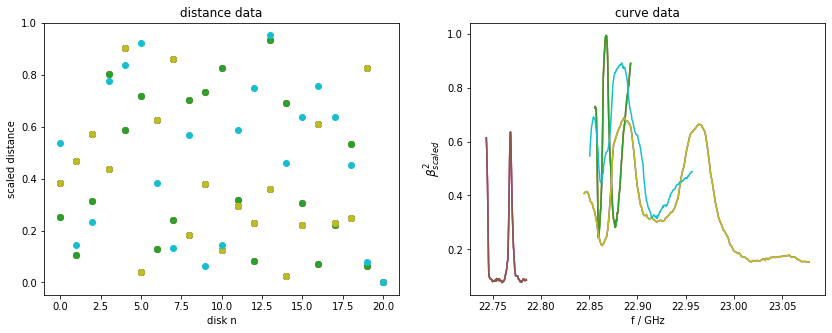

In [14]:
#@title Plot transformed
fig, axs = plt.subplots(1, 2, figsize=(14,5)) 

for i in range(10):    
    yax = Xt_train[i]
    xax = range(len(yax))
    axs[0].scatter(xax, yax, label=i)
    axs[0].set_xlabel("disk n")
    axs[0].set_ylabel("scaled distance")
        
    xax = f_train[i]
    yax = yt_train[i]
    #xax = range(len(yax))
    axs[1].plot(xax, yax, label=i)
    axs[1].set_xlabel("f / GHz")
    axs[1].set_ylabel(r"$\beta^2_{scaled}$",fontsize=12)

axs[0].set_title("distance data")
axs[1].set_title("curve data");

/home/anovak/software/miniconda3/envs/def/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


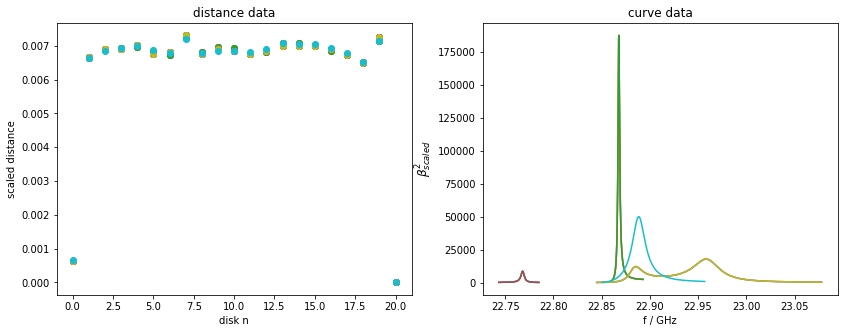

In [15]:
#@title Plot inverse transform roundtrip
fig, axs = plt.subplots(1, 2, figsize=(14,5)) 
Xi = scalerX.inverse_transform(Xt_train)
yi = scalerY.inverse_transform(yt_train)
fi = scalerF.inverse_transform(f_train)

for i in range(10):    
    yax = Xi[i]
    xax = range(len(yax))
    axs[0].scatter(xax, yax, label=i)
    axs[0].set_xlabel("disk n")
    axs[0].set_ylabel("scaled distance")
        
    yax = yi[i]
    #xax = range(len(yax))
    xax = fi[i]
    xax[xax < 1] = np.nan
    axs[1].plot(xax, yax, label=i)
    axs[1].set_xlabel("f / GHz")
    axs[1].set_ylabel(r"$\beta^2_{scaled}$",fontsize=12)
    
axs[0].set_title("distance data")
axs[1].set_title("curve data");

In [16]:
abs(f_train[:, 0].reshape((-1, 1)) - f_train[:, -1].reshape((-1, 1))).shape

(1617, 1)

In [17]:
Xa_train = np.hstack([Xt_train, f_train[:, 0].reshape((-1, 1)),
                     abs(f_train[:, 0].reshape((-1, 1)) - f_train[:, -1].reshape((-1, 1)))
                     ])
Xa_test = np.hstack([Xt_test, f_test[:, 0].reshape((-1, 1)),
                     abs(f_test[:, 0].reshape((-1, 1)) - f_test[:, -1].reshape((-1, 1)))
                    ])

In [19]:
#@title Actual training
model = Sequential()
model.add(Dense(1000, input_dim=23, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='linear'))

kldiv = tf.keras.losses.KLDivergence()

# Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer

def shape_loss(y_true, y_pred):
    y_true, y_pred = y_true[:, :-2], y_pred[:, :-2]
    return (kldiv(y_true,y_pred) + kldiv(y_pred, y_true))/10 + tf.keras.losses.mse(y_true,y_pred)*10

def freq_loss(y_true, y_pred):
    y_true, y_pred = y_true[:, -2:], y_pred[:, -2:]
    return tf.keras.losses.mse(y_true,y_pred)

def custom_loss(y_true,y_pred):
    return shape_loss(y_true, y_pred)/4 + freq_loss(y_true, y_pred)
   
model.compile(optimizer = "adam", loss=custom_loss, metrics=['mse', shape_loss, freq_loss])

#history=model.fit(Xt_train, yt_train, epochs=20, verbose=1,validation_split=0.2)
history=model.fit(Xa_train, yt_train, epochs=30, verbose=1,validation_split=0.2)

Train on 1293 samples, validate on 324 samples
Epoch 1/30
1293/1293 [==============================] - 3s 2ms/sample - loss: 8.7409 - mse: 0.6344 - shape_loss: 33.2911 - freq_loss: 0.4181 - val_loss: 2.5159 - val_mse: 0.1645 - val_shape_loss: 9.6243 - val_freq_loss: 0.1098
Epoch 2/30
1293/1293 [==============================] - 1s 569us/sample - loss: 3.0663 - mse: 0.1640 - shape_loss: 11.7386 - freq_loss: 0.1317 - val_loss: 2.1890 - val_mse: 0.1232 - val_shape_loss: 8.3857 - val_freq_loss: 0.0925
Epoch 3/30
1293/1293 [==============================] - 1s 615us/sample - loss: 2.6955 - mse: 0.1493 - shape_loss: 10.2698 - freq_loss: 0.1280 - val_loss: 1.6851 - val_mse: 0.0964 - val_shape_loss: 6.3172 - val_freq_loss: 0.1058
Epoch 4/30
1293/1293 [==============================] - 1s 613us/sample - loss: 1.8637 - mse: 0.1072 - shape_loss: 7.0623 - freq_loss: 0.0981 - val_loss: 1.6147 - val_mse: 0.0926 - val_shape_loss: 6.0823 - val_freq_loss: 0.0941
Epoch 5/30
1293/1293 [==================

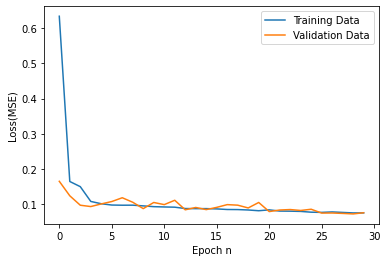

In [28]:
#@title Plot loss
plt.plot(history.history['mse'],label='Training Data')
plt.plot(history.history['val_mse'],label='Validation Data')
plt.xlabel("Epoch n")
plt.ylabel("Loss(MSE)")
plt.legend()

In [29]:
predictions = model.predict(Xa_test)

In [30]:
predi = scalerY.inverse_transform(predictions)
predi_truth = scalerY.inverse_transform(yt_test)

In [31]:
ixes = np.random.choice(np.arange(100), 16)

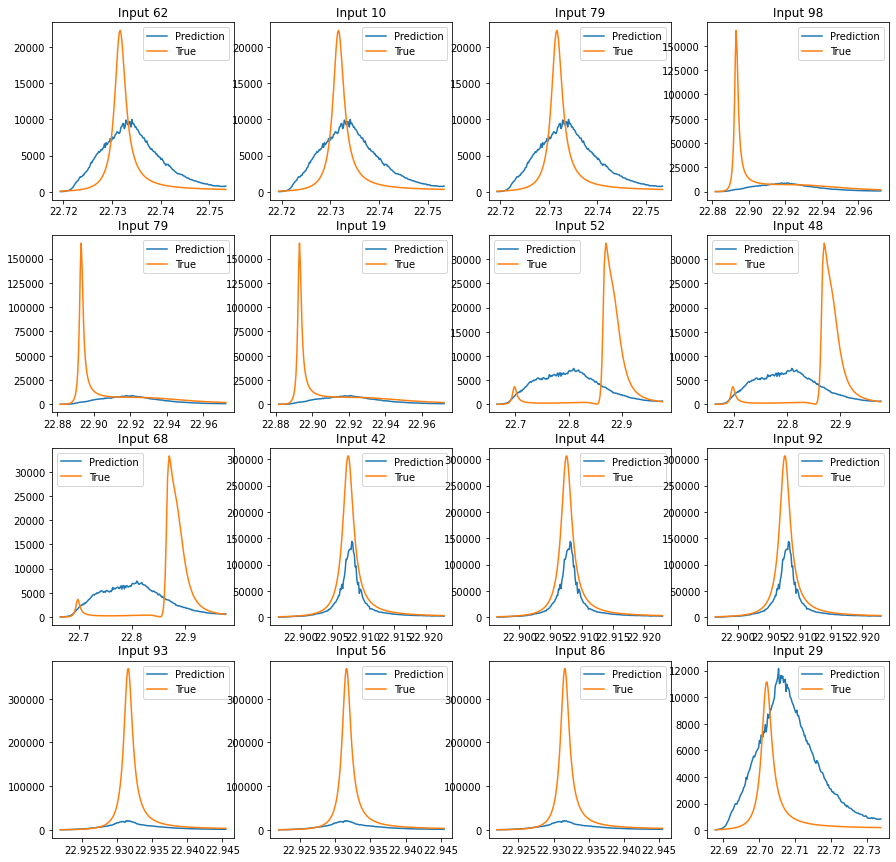

In [32]:
#@title Plot evaluation examples
fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
for i, j in enumerate(ixes):
    _f = np.linspace(Xa_test[i][-2], Xa_test[i][-2]+Xa_test[i][-1], 200)
    _pred = predi[i]
    _tru = predi_truth[i]
    axs[i].plot(_f, _pred, label="Prediction")
    axs[i].plot(_f, _tru, label="True")
    #axs[i].set_xlim(22.7, 23)
    axs[i].legend()
    axs[i].set_title(f"Input {j}")

## Predict at unseen ranges

In [33]:
Xa_test_shift = Xa_test.copy()
Xa_test_shift[:, -2] = Xa_test[:, -2] + 0.05

# Xa_test_shift = np.hstack([Xt_test, f_testS[:, 0].reshape((-1, 1)),
#                            abs(f_testS[:, 0].reshape((-1, 1)) - f_testS[:, -1].reshape((-1, 1)))
#                           ])

predictions_sh = model.predict(Xa_test_shift)

predi_sh = scalerY.inverse_transform(predictions_sh)

In [34]:
Xa_test_shift - Xa_test

array([[0.  , 0.  , 0.  , ..., 0.  , 0.05, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.05, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.05, 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.05, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.05, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.05, 0.  ]])

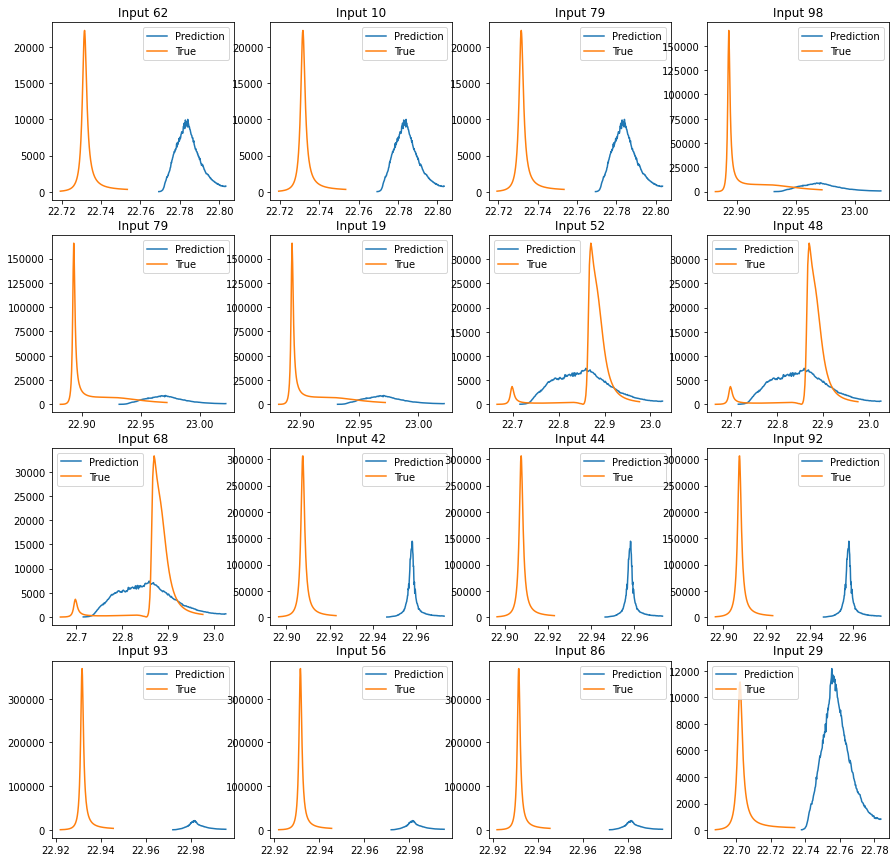

In [35]:
#@title Plot evaluation examples
fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
for i, j in enumerate(ixes):
    _f_tru = np.linspace(Xa_test[i][-2], Xa_test[i][-2]+Xa_test[i][-1], 200)
    _f_pred = np.linspace(Xa_test_shift[i][-2], Xa_test_shift[i][-2]+Xa_test_shift[i][-1], 200)
    _pred = predi_sh[i]
    _tru = predi_truth[i]
    axs[i].plot(_f_pred, _pred, label="Prediction")
    axs[i].plot(_f_tru, _tru, label="True")
    #axs[i].set_xlim(22.7, 23)
    axs[i].legend()
    axs[i].set_title(f"Input {j}")